## Data: Online Payments Fraud Detection

## Import Necessary Libraries

In [6]:
# !pip install xgboost

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

## Load and Explore the Dataset

In [8]:
# Load the dataset
df = pd.read_csv("D:/ML-Project/Datasets/fraud_detection.csv")

In [9]:
# Display the first few rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## Feature Explanations

1. **step**: Represents a unit of time, where each step corresponds to one hour of observation. Useful for analyzing temporal transaction patterns.
2. **type**: Indicates the type of transaction, such as 'CASH-IN', 'CASH-OUT', 'DEBIT', 'PAYMENT', and 'TRANSFER'.
3. **amount**: The amount of money involved in the transaction, important for identifying unusual monetary values.
4. **nameOrig**: Identifier of the account initiating the transaction, useful for tracking account activity.
5. **oldbalanceOrg**: The account balance of the origin account before the transaction.
6. **newbalanceOrig**: The account balance of the origin account after the transaction.
7. **nameDest**: Identifier of the account receiving the transaction, useful for tracking account activity.
8. **oldbalanceDest**: The account balance of the destination account before the transaction.
9. **newbalanceDest**: The account balance of the destination account after the transaction.
10. **isFraud**: Binary indicator of whether the transaction is fraudulent (1) or not (0), used as the target variable in fraud detection models.

In [10]:
# Display basic info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 80.0+ MB


In [11]:
# Display summary statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2.696617e+01,1.586670e+05,8.740095e+05,8.938089e+05,9.781600e+05,1.114198e+06,1.089097e-03
std,1.562325e+01,2.649409e+05,2.971751e+06,3.008271e+06,2.296780e+06,2.416593e+06,3.298351e-02
min,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,1.214907e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+01,7.634333e+04,1.600200e+04,0.000000e+00,1.263772e+05,2.182604e+05,0.000000e+00
75%,3.900000e+01,2.137619e+05,1.366420e+05,1.746000e+05,9.159235e+05,1.149808e+06,0.000000e+00
max,9.500000e+01,1.000000e+07,3.890000e+07,3.890000e+07,4.210000e+07,4.220000e+07,1.000000e+00


## Summary Statistics Explanation

### Explanation of Features and Summary Statistics

1. **step**: Represents a unit of time, where each step corresponds to one hour of observation. Useful for analyzing temporal transaction patterns.
   - **Mean**: The average step value is 26.97, indicating transactions are spread over approximately 27 hours on average.
   - **Std**: Standard deviation of 15.62 suggests moderate variability in the time of transactions.
   - **Min**: The earliest transaction occurs at step 1.
   - **Max**: The latest transaction occurs at step 95.

2. **amount**: The amount of money involved in the transaction, important for identifying unusual monetary values.
   - **Mean**: Average transaction amount is 158,667.00 units.
   - **Std**: High standard deviation of 264,940.90 indicates a wide range of transaction amounts.
   - **Min**: Smallest transaction amount is 0.10.
   - **Max**: Largest transaction amount is 10,000,000.00.

3. **oldbalanceOrg**: The account balance of the origin account before the transaction.
   - **Mean**: Average original balance is 874,009.50.
   - **Std**: High standard deviation of 2,971,751.00 indicates significant variability.
   - **Min**: Some transactions have an original balance of 0.00.
   - **Max**: Maximum original balance is 38,900,000.00.

4. **newbalanceOrig**: The account balance of the origin account after the transaction.
   - **Mean**: Average new balance is 893,808.90.
   - **Std**: Standard deviation of 3,008,271.00 suggests high variability.
   - **Min**: Some transactions result in a new balance of 0.00.
   - **Max**: Maximum new balance is 38,900,000.00.

5. **oldbalanceDest**: The account balance of the destination account before the transaction.
   - **Mean**: Average original balance of the destination account is 978,160.00.
   - **Std**: Standard deviation of 2,296,780.00 indicates substantial variability.
   - **Min**: Some destination accounts have an original balance of 0.00.
   - **Max**: Highest original balance is 42,100,000.00.

6. **newbalanceDest**: The account balance of the destination account after the transaction.
   - **Mean**: Average new balance of the destination account is 1,114,198.00.
   - **Std**: Standard deviation of 2,416,593.00 shows considerable variability.
   - **Min**: Some transactions result in a new balance of 0.00.
   - **Max**: Maximum new balance is 42,200,000.00.

7. **isFraud**: A binary indicator of whether the transaction is fraudulent (1) or not (0).
   - **Mean**: Average value of 0.00109 indicates a very small proportion of transactions are fraudulent.
   - **Std**: Standard deviation of 0.03298 reflects the imbalance between fraudulent and non-fraudulent transactions.
   - **Min**: Minimum value is 0 (non-fraudulent).
   - **Max**: Maximum value is 1 (fraudulent).

In [12]:
# Check the distribution of class labels
class_distribution = df['isFraud'].value_counts()
print("Class distribution:")
print(class_distribution)

# Calculate and print the percentage distribution
class_percentage = df['isFraud'].value_counts(normalize=True) * 100
print("\nClass percentage distribution:")
print(class_percentage)

Class distribution:
0    1047433
1       1142
Name: isFraud, dtype: int64

Class percentage distribution:
0    99.89109
1     0.10891
Name: isFraud, dtype: float64


## Data Cleaning

In [13]:
# Check for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

### There are no null values in our data.

## Exploratory Data Analysis (EDA)

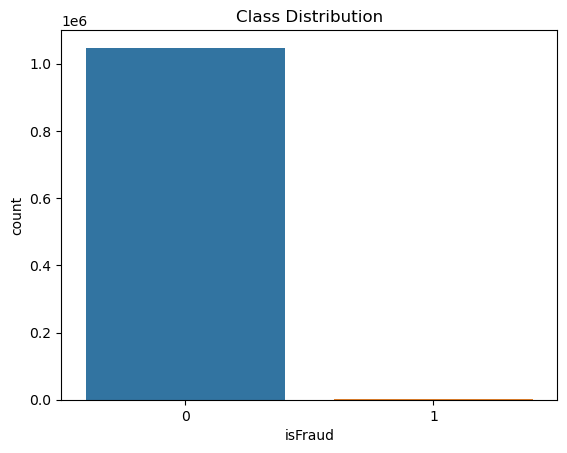

In [14]:
# Visualize class distribution
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution')
plt.show()

## Class Distribution

The class distribution of the `isFraud` feature provides insights into the balance between fraudulent and non-fraudulent transactions in the dataset.

- **Non-Fraudulent Transactions (0)**: 1,047,433 instances
- **Fraudulent Transactions (1)**: 1,142 instances

This indicates a significant imbalance between the two classes.

### Class Percentage Distribution

- **Non-Fraudulent Transactions (0)**: 99.89109%
- **Fraudulent Transactions (1)**: 0.10891%

This percentage distribution highlights the severe imbalance in the dataset. Nearly 99.89% of the transactions are non-fraudulent, while only 0.11% are fraudulent. Such imbalance is common in fraud detection datasets and poses challenges for machine learning models, which may tend to favor the majority class (non-fraudulent transactions) and perform poorly on the minority class (fraudulent transactions).

### Imbalance Implications

The dataset is highly imbalanced, with non-fraudulent transactions vastly outnumbering fraudulent transactions. This imbalance poses several challenges for machine learning models:

- **Bias-Variance Trade-off**: Models may achieve high accuracy by predicting the majority class but fail to generalize well on the minority class.
- **Overfitting**: The model might overfit to the majority class and consider the minority class as noise.
- **Evaluation Metrics**: Accuracy alone is not a good measure of performance in this case. Metrics like precision, recall, F1-score, and area under the ROC curve are more informative for imbalanced datasets.

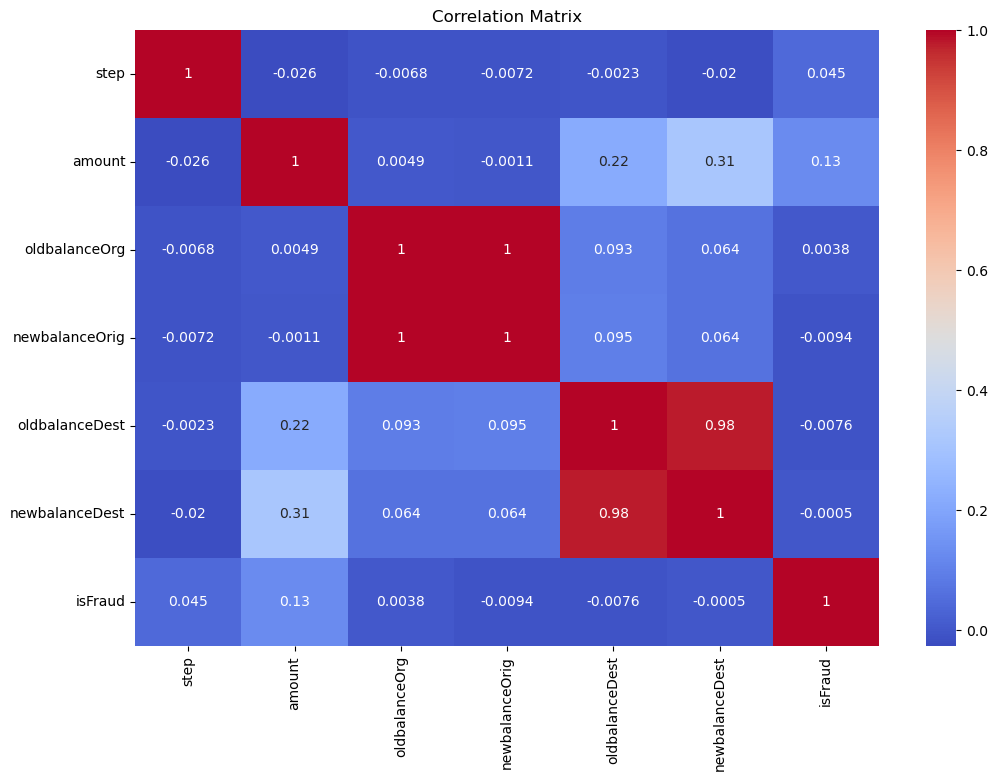

In [15]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Data Structure and Distribution of Transaction Types

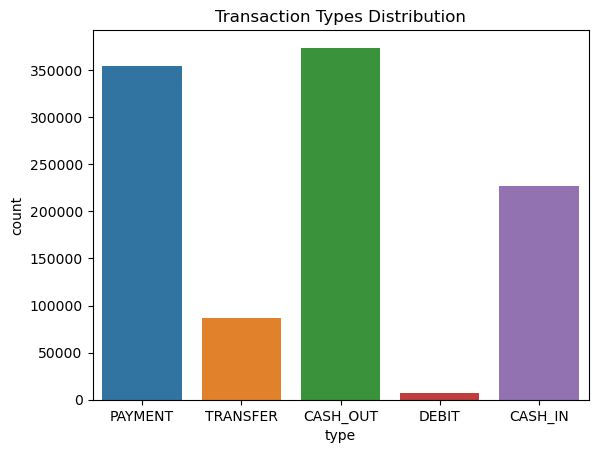

In [16]:
# Distribution of transaction types
sns.countplot(x='type', data=df)
plt.title('Transaction Types Distribution')
plt.show()

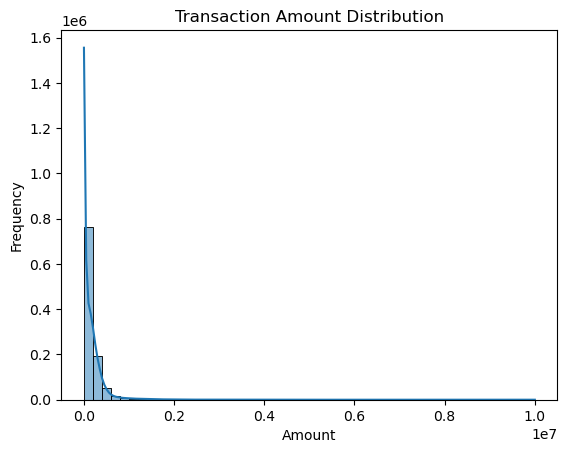

In [17]:
# Distribution of transaction amounts
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

### Temporal Patterns in Fraudulent Transactions

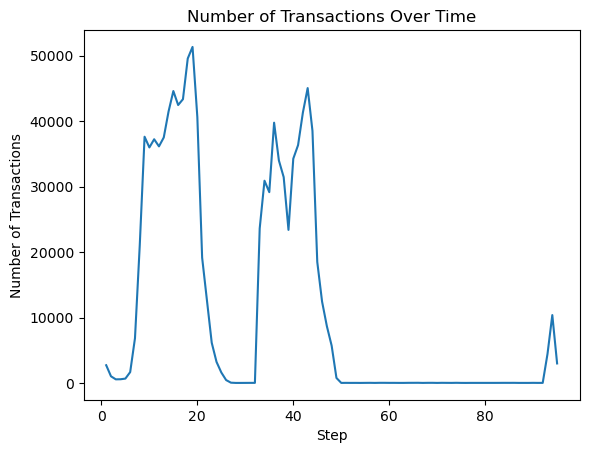

In [18]:
# Plot number of transactions over time
df.groupby('step')['isFraud'].count().plot()
plt.title('Number of Transactions Over Time')
plt.xlabel('Step')
plt.ylabel('Number of Transactions')
plt.show()

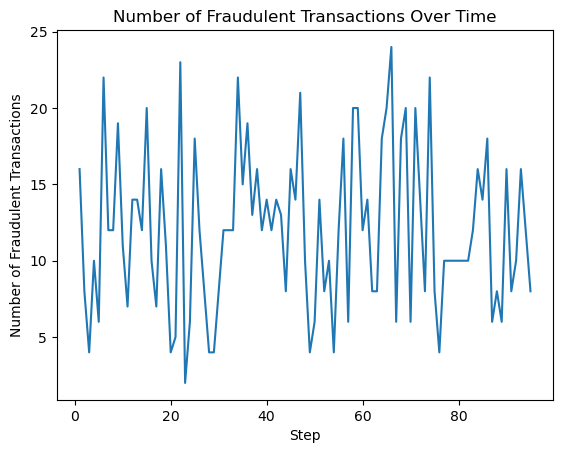

In [19]:
# Plot number of fraudulent transactions over time
df[df['isFraud'] == 1].groupby('step')['isFraud'].count().plot()
plt.title('Number of Fraudulent Transactions Over Time')
plt.xlabel('Step')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

### Analyze Balance Changes

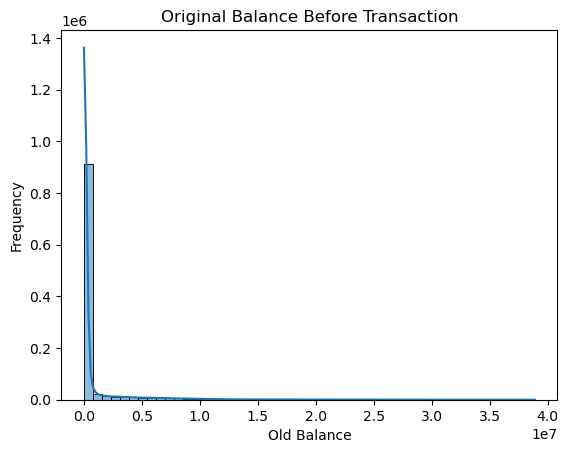

In [20]:
# Distribution of old balance before transaction
sns.histplot(df['oldbalanceOrg'], bins=50, kde=True)
plt.title('Original Balance Before Transaction')
plt.xlabel('Old Balance')
plt.ylabel('Frequency')
plt.show()

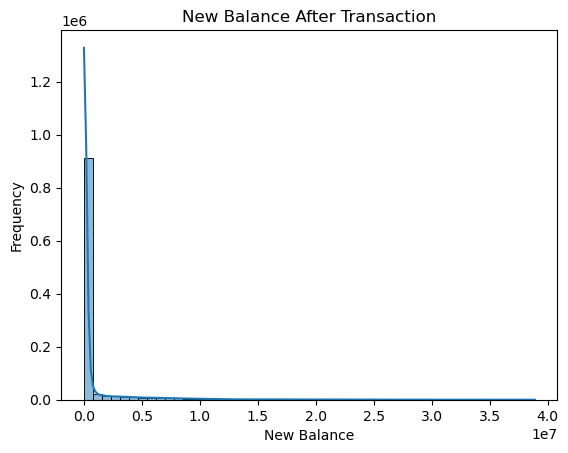

In [21]:
# Distribution of new balance after transaction
sns.histplot(df['newbalanceOrig'], bins=50, kde=True)
plt.title('New Balance After Transaction')
plt.xlabel('New Balance')
plt.ylabel('Frequency')
plt.show()

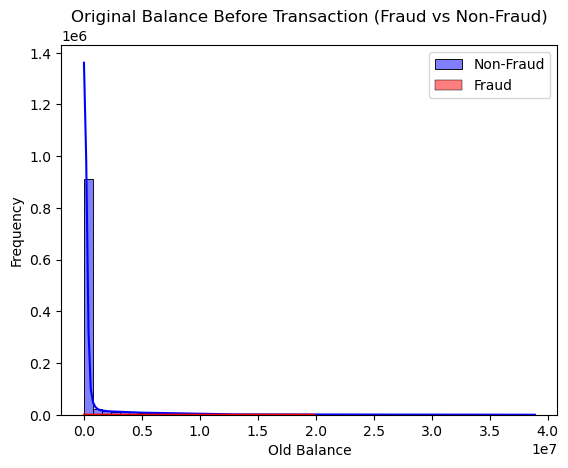

In [22]:
# Distribution of old balance before transaction for fraud and non-fraud
sns.histplot(df[df['isFraud'] == 0]['oldbalanceOrg'], bins=50, kde=True, color='blue', label='Non-Fraud')
sns.histplot(df[df['isFraud'] == 1]['oldbalanceOrg'], bins=50, kde=True, color='red', label='Fraud')
plt.title('Original Balance Before Transaction (Fraud vs Non-Fraud)')
plt.xlabel('Old Balance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Unique and Frequent Entities

In [23]:
# Unique names in origin and destination
unique_origins = df['nameOrig'].nunique()
unique_destinations = df['nameDest'].nunique()

print(f"Unique transaction origins: {unique_origins}")
print(f"Unique transaction destinations: {unique_destinations}")

Unique transaction origins: 1048317
Unique transaction destinations: 449635


In [24]:
# Most frequent transaction origins
top_origins = df['nameOrig'].value_counts().head(10)
print("Top 10 Transaction Origins:\n", top_origins)

Top 10 Transaction Origins:
 C1214450722    2
C309111136     2
C1268675361    2
C720460198     2
C1109092856    2
C545402485     2
C1362689728    2
C110179857     2
C1467095135    2
C2073023524    2
Name: nameOrig, dtype: int64


In [25]:
# Most frequent transaction destinations
top_destinations = df['nameDest'].value_counts().head(10)
print("Top 10 Transaction Destinations:\n", top_destinations)

Top 10 Transaction Destinations:
 C985934102     98
C1286084959    96
C1590550415    89
C248609774     88
C665576141     87
C2083562754    86
C977993101     82
C1360767589    81
C451111351     80
C306206744     79
Name: nameDest, dtype: int64


## Feature Selection

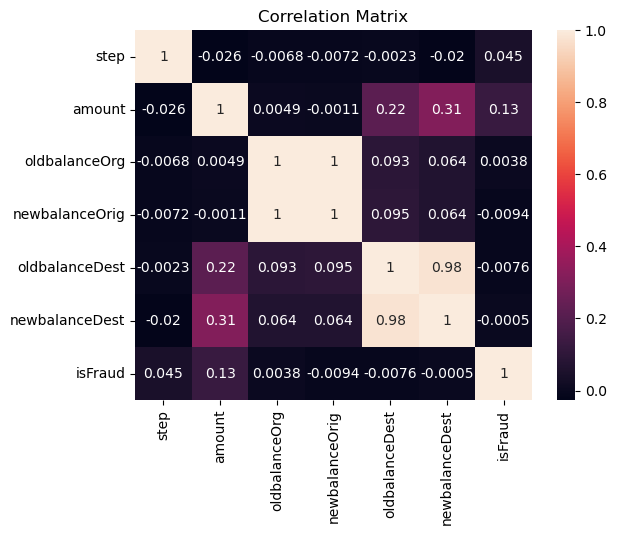

Selected Features:  ['amount', 'step', 'newbalanceOrig', 'oldbalanceDest', 'oldbalanceOrg', 'newbalanceDest']


In [26]:
# Correlation matrix
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

# Select features based on correlation with target variable
selected_features = correlation_matrix['isFraud'].abs().sort_values(ascending=False).index[1:7].tolist()
print("Selected Features: ", selected_features)

### Feature Selection Technique

**Correlation-based Feature Selection (CFS)**
- **Simplicity**: Effective for initial analysis.
- **Relevance**: Selects highly correlated features with the target and low inter-correlation among features.
- **Efficiency**: Reduces dimensionality, improving model performance and training speed.

## Cross-Validation and Sample Split

In [27]:
# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define train/validation/test split
X = df[selected_features]
y = df['isFraud']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 734002
Validation set size: 210763
Test set size: 103810


In [28]:
X_train.head()

,amount,step,newbalanceOrig,oldbalanceDest,oldbalanceOrg,newbalanceDest
585327,59005.75,33,0.00,0.00,20950.00,59005.75
65578,19920.17,9,24575.83,0.00,44496.00,0.00
446123,141429.92,19,0.00,2601102.28,13404.00,2742532.20
842411,117581.97,41,0.00,180713.32,0.00,298295.29
86621,1203530.73,10,0.00,1253187.80,54511.59,2456718.53


In [29]:
X_val.head()

,amount,step,newbalanceOrig,oldbalanceDest,oldbalanceOrg,newbalanceDest
25315,9400.24,8,2079.76,0.00,11480.00,0.00
790413,240074.93,40,0.00,494579.22,650.00,734654.15
508676,119790.21,20,0.00,23804.50,40677.00,143594.71
88055,704828.07,10,0.00,1773049.23,48230.02,2477877.29
222566,65707.61,14,3723271.46,2701109.06,3657563.85,2635401.45


### Cross-Validation

**Stratified K-Fold Cross-Validation**
- **Stratification**: Ensures proportional representation of classes in each fold.
- **Robustness**: Provides comprehensive model evaluation, reducing overfitting risk.
- **Parameters**:
  - **Number of Folds**: 5

### Sample Sizes

**Training/Validation/Test Split**: 70/20/10
- **Training Set (70%)**: Sufficient data for learning.
- **Validation Set (20%)**: For hyperparameter tuning and evaluation.
- **Test Set (10%)**: For unbiased evaluation of final model performance.

# Baseline execution on imbalanced data

# Model Training and Evaluation

## **Logistic Regression**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_lr = LogisticRegression(random_state=42)

# Train the model on the training set
model_lr.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = model_lr.predict(X_val)
y_pred_proba_val = model_lr.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
mcc_val = matthews_corrcoef(y_val, y_pred_val)

# Evaluate the model on the test set
y_pred_test = model_lr.predict(X_test)
y_pred_proba_test = model_lr.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)
mcc_test = matthews_corrcoef(y_test, y_pred_test)

# Display results for the validation set
results_val = {
    "Dataset": "Validation",
    "Precision": precision_val,
    "Recall": recall_val,
    "F1-Score": f1_val,
    "AUC-ROC": auc_val,
    "MCC": mcc_val
}

# Display results for the test set
results_test = {
    "Dataset": "Test",
    "Precision": precision_test,
    "Recall": recall_test,
    "F1-Score": f1_test,
    "AUC-ROC": auc_test,
    "MCC": mcc_test
}

print("Validation Set Results:")
print(results_val)
print("\nTest Set Results:")
print(results_test)

Validation Set Results:
{'Dataset': 'Validation', 'Precision': 0.46808510638297873, 'Recall': 0.28695652173913044, 'F1-Score': 0.3557951482479784, 'AUC-ROC': 0.8476521805215294, 'MCC': 0.3659647029243767}

Test Set Results:
{'Dataset': 'Test', 'Precision': 0.5454545454545454, 'Recall': 0.37168141592920356, 'F1-Score': 0.4421052631578947, 'AUC-ROC': 0.8557319098759566, 'MCC': 0.4497744421672175}


## **Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_rf = RandomForestClassifier(random_state=42)

# Train the model on the training set
model_rf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_rf = model_rf.predict(X_val)
y_pred_proba_val_rf = model_rf.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_rf = precision_score(y_val, y_pred_val_rf)
recall_val_rf = recall_score(y_val, y_pred_val_rf)
f1_val_rf = f1_score(y_val, y_pred_val_rf)
auc_val_rf = roc_auc_score(y_val, y_pred_proba_val_rf)
mcc_val_rf = matthews_corrcoef(y_val, y_pred_val_rf)

# Evaluate the model on the test set
y_pred_test_rf = model_rf.predict(X_test)
y_pred_proba_test_rf = model_rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_rf = precision_score(y_test, y_pred_test_rf)
recall_test_rf = recall_score(y_test, y_pred_test_rf)
f1_test_rf = f1_score(y_test, y_pred_test_rf)
auc_test_rf = roc_auc_score(y_test, y_pred_proba_test_rf)
mcc_test_rf = matthews_corrcoef(y_test, y_pred_test_rf)

# Display results for the validation set
results_val_rf = {
    "Dataset": "Validation",
    "Precision": precision_val_rf,
    "Recall": recall_val_rf,
    "F1-Score": f1_val_rf,
    "AUC-ROC": auc_val_rf,
    "MCC": mcc_val_rf
}

# Display results for the test set
results_test_rf = {
    "Dataset": "Test",
    "Precision": precision_test_rf,
    "Recall": recall_test_rf,
    "F1-Score": f1_test_rf,
    "AUC-ROC": auc_test_rf,
    "MCC": mcc_test_rf
}

print("Validation Set Results for Random Forest:")
print(results_val_rf)
print("\nTest Set Results for Random Forest:")
print(results_test_rf)

Validation Set Results for Random Forest:
{'Dataset': 'Validation', 'Precision': 1.0, 'Recall': 0.6869565217391305, 'F1-Score': 0.8144329896907216, 'AUC-ROC': 0.9843709103540311, 'MCC': 0.8286867142559904}

Test Set Results for Random Forest:
{'Dataset': 'Test', 'Precision': 0.9878048780487805, 'Recall': 0.7168141592920354, 'F1-Score': 0.8307692307692308, 'AUC-ROC': 0.9772561072034155, 'MCC': 0.8413333844208215}


## **Gradient Boosting**

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Initialize Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42)

# Train the model on the training set
model_gb.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_gb = model_gb.predict(X_val)
y_pred_proba_val_gb = model_gb.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_gb = precision_score(y_val, y_pred_val_gb)
recall_val_gb = recall_score(y_val, y_pred_val_gb)
f1_val_gb = f1_score(y_val, y_pred_val_gb)
auc_val_gb = roc_auc_score(y_val, y_pred_proba_val_gb)
mcc_val_gb = matthews_corrcoef(y_val, y_pred_val_gb)

# Evaluate the model on the test set
y_pred_test_gb = model_gb.predict(X_test)
y_pred_proba_test_gb = model_gb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_gb = precision_score(y_test, y_pred_test_gb)
recall_test_gb = recall_score(y_test, y_pred_test_gb)
f1_test_gb = f1_score(y_test, y_pred_test_gb)
auc_test_gb = roc_auc_score(y_test, y_pred_proba_test_gb)
mcc_test_gb = matthews_corrcoef(y_test, y_pred_test_gb)

# Display results for the validation set
results_val_gb = {
    "Dataset": "Validation",
    "Precision": precision_val_gb,
    "Recall": recall_val_gb,
    "F1-Score": f1_val_gb,
    "AUC-ROC": auc_val_gb,
    "MCC": mcc_val_gb
}

# Display results for the test set
results_test_gb = {
    "Dataset": "Test",
    "Precision": precision_test_gb,
    "Recall": recall_test_gb,
    "F1-Score": f1_test_gb,
    "AUC-ROC": auc_test_gb,
    "MCC": mcc_test_gb
}

print("Validation Set Results for Gradient Boosting:")
print(results_val_gb)
print("\nTest Set Results for Gradient Boosting:")
print(results_test_gb)

Validation Set Results for Gradient Boosting:
{'Dataset': 'Validation', 'Precision': 0.8742138364779874, 'Recall': 0.6043478260869565, 'F1-Score': 0.7146529562982005, 'AUC-ROC': 0.9801691937585328, 'MCC': 0.7266258266745376}

Test Set Results for Gradient Boosting:
{'Dataset': 'Test', 'Precision': 0.9342105263157895, 'Recall': 0.6283185840707964, 'F1-Score': 0.7513227513227513, 'AUC-ROC': 0.9648490867837294, 'MCC': 0.7659519663327976}


## **XGBoost**

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_xgb = XGBClassifier(scale_pos_weight=(len(y) - sum(y)) / sum(y),
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

# Train the model on the training set
model_xgb.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_xgb = model_xgb.predict(X_val)
y_pred_proba_val_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_xgb = precision_score(y_val, y_pred_val_xgb)
recall_val_xgb = recall_score(y_val, y_pred_val_xgb)
f1_val_xgb = f1_score(y_val, y_pred_val_xgb)
auc_val_xgb = roc_auc_score(y_val, y_pred_proba_val_xgb)
mcc_val_xgb = matthews_corrcoef(y_val, y_pred_val_xgb)

# Evaluate the model on the test set
y_pred_test_xgb = model_xgb.predict(X_test)
y_pred_proba_test_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_xgb = precision_score(y_test, y_pred_test_xgb)
recall_test_xgb = recall_score(y_test, y_pred_test_xgb)
f1_test_xgb = f1_score(y_test, y_pred_test_xgb)
auc_test_xgb = roc_auc_score(y_test, y_pred_proba_test_xgb)
mcc_test_xgb = matthews_corrcoef(y_test, y_pred_test_xgb)

# Display results for the validation set
results_val_xgb = {
    "Dataset": "Validation",
    "Precision": precision_val_xgb,
    "Recall": recall_val_xgb,
    "F1-Score": f1_val_xgb,
    "AUC-ROC": auc_val_xgb,
    "MCC": mcc_val_xgb
}

# Display results for the test set
results_test_xgb = {
    "Dataset": "Test",
    "Precision": precision_test_xgb,
    "Recall": recall_test_xgb,
    "F1-Score": f1_test_xgb,
    "AUC-ROC": auc_test_xgb,
    "MCC": mcc_test_xgb
}

print("Validation Set Results for XGBoost:")
print(results_val_xgb)
print("\nTest Set Results for XGBoost:")
print(results_test_xgb)

Validation Set Results for XGBoost:
{'Dataset': 'Validation', 'Precision': 0.5662983425414365, 'Recall': 0.8913043478260869, 'F1-Score': 0.6925675675675675, 'AUC-ROC': 0.9986763925680142, 'MCC': 0.7100817237961484}

Test Set Results for XGBoost:
{'Dataset': 'Test', 'Precision': 0.5857988165680473, 'Recall': 0.8761061946902655, 'F1-Score': 0.7021276595744681, 'AUC-ROC': 0.9881350199923006, 'MCC': 0.716036505750019}


## **Neural Network (Multi-layer Perceptron)**

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_nn = MLPClassifier(random_state=42)

# Train the model on the training set
model_nn.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_nn = model_nn.predict(X_val)
# Check if the model has the predict_proba method
y_pred_proba_val_nn = model_nn.predict_proba(X_val)[:, 1] if hasattr(model_nn, "predict_proba") else None

# Calculate evaluation metrics for the validation set
precision_val_nn = precision_score(y_val, y_pred_val_nn)
recall_val_nn = recall_score(y_val, y_pred_val_nn)
f1_val_nn = f1_score(y_val, y_pred_val_nn)
auc_val_nn = roc_auc_score(y_val, y_pred_proba_val_nn) if y_pred_proba_val_nn is not None else None
mcc_val_nn = matthews_corrcoef(y_val, y_pred_val_nn)

# Evaluate the model on the test set
y_pred_test_nn = model_nn.predict(X_test)
# Check if the model has the predict_proba method
y_pred_proba_test_nn = model_nn.predict_proba(X_test)[:, 1] if hasattr(model_nn, "predict_proba") else None

# Calculate evaluation metrics for the test set
precision_test_nn = precision_score(y_test, y_pred_test_nn)
recall_test_nn = recall_score(y_test, y_pred_test_nn)
f1_test_nn = f1_score(y_test, y_pred_test_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_proba_test_nn) if y_pred_proba_test_nn is not None else None
mcc_test_nn = matthews_corrcoef(y_test, y_pred_test_nn)

# Display results for the validation set
results_val_nn = {
    "Dataset": "Validation",
    "Precision": precision_val_nn,
    "Recall": recall_val_nn,
    "F1-Score": f1_val_nn,
    "AUC-ROC": auc_val_nn,
    "MCC": mcc_val_nn
}

# Display results for the test set
results_test_nn = {
    "Dataset": "Test",
    "Precision": precision_test_nn,
    "Recall": recall_test_nn,
    "F1-Score": f1_test_nn,
    "AUC-ROC": auc_test_nn,
    "MCC": mcc_test_nn
}

print("Validation Set Results for Neural Network:")
print(results_val_nn)
print("\nTest Set Results for Neural Network:")
print(results_test_nn)

Validation Set Results for Neural Network:
{'Dataset': 'Validation', 'Precision': 0.33783783783783783, 'Recall': 0.43478260869565216, 'F1-Score': 0.38022813688212925, 'AUC-ROC': 0.8477134432503507, 'MCC': 0.38249643203623335}

Test Set Results for Neural Network:
{'Dataset': 'Test', 'Precision': 0.35714285714285715, 'Recall': 0.4424778761061947, 'F1-Score': 0.3952569169960474, 'AUC-ROC': 0.8398138944803534, 'MCC': 0.396799040582314}


## Classification Algorithms

1. **Logistic Regression**
   - **Simple and interpretable baseline model.**

2. **Random Forest**
   - **Handles non-linear relationships and is robust to overfitting.**

3. **Gradient Boosting (GB)**
   - **Builds sequentially to correct errors, effective for imbalanced datasets, high accuracy.**.

4. **XGBoost (Extreme Gradient Boosting):**
   - **Effective for imbalanced datasets, high accuracy.**

5. **Neural Network (MLPClassifier)**
   - **Captures complex patterns and interactions in data.**

## Performance Metrics Related to Minority Class

1. **Precision**
   - Accuracy of positive predictions (fraud cases).

2. **Recall (Sensitivity)**
   - Ability to identify actual fraud cases.

3. **F1-Score**
   - Balanced measure of precision and recall.

4. **Area Under the ROC Curve (AUC-ROC)**
   - Discrimination ability across all threshold values.

5. **Matthews Correlation Coefficient (MCC)**
   - Comprehensive performance measure, even with imbalanced classes.

# Apply SMOTE to Balance Classes

In [35]:
# !pip install scikit-learn==1.0.2
# !pip install imbalanced-learn==0.8.1

In [39]:
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# Apply SMOTE
smote = SMOTE(random_state=42)
X_re_smote, y_re_smote = smote.fit_resample(X_train, y_train)


# Convert the resampled data to a DataFrame
resampled_data = pd.DataFrame(X_re_smote, columns=X.columns)
resampled_data['isFraud'] = y_re_smote


# Save the resampled data to a CSV file
resampled_data.to_csv('Fraud_Detection_Smote.csv', index=False)

In [41]:
df = pd.read_csv("D:/ML-Project/Balanced Datasets/Fraud_Detection_Smote.csv")
df.head()

,amount,step,newbalanceOrig,oldbalanceDest,oldbalanceOrg,newbalanceDest,isFraud
0,59005.75,33,0.00,0.00,20950.00,59005.75,0
1,19920.17,9,24575.83,0.00,44496.00,0.00,0
2,141429.92,19,0.00,2601102.28,13404.00,2742532.20,0
3,117581.97,41,0.00,180713.32,0.00,298295.29,0
4,1203530.73,10,0.00,1253187.80,54511.59,2456718.53,0


In [ ]:
# Check the distribution of class labels
class_distribution = df['isFraud'].value_counts()
print("Class distribution:")
print(class_distribution)

# Calculate and print the percentage distribution
class_percentage = df['isFraud'].value_counts(normalize=True) * 100
print("\nClass percentage distribution:")
print(class_percentage)

Class distribution:
0    733203
1    733203
Name: isFraud, dtype: int64

Class percentage distribution:
0    50.0
1    50.0
Name: isFraud, dtype: float64


Here we can see that classes are balanced now.

In [42]:
X_re_smote.head()

,amount,step,newbalanceOrig,oldbalanceDest,oldbalanceOrg,newbalanceDest,isFraud
0,59005.75,33,0.00,0.00,20950.00,59005.75,0
1,19920.17,9,24575.83,0.00,44496.00,0.00,0
2,141429.92,19,0.00,2601102.28,13404.00,2742532.20,0
3,117581.97,41,0.00,180713.32,0.00,298295.29,0
4,1203530.73,10,0.00,1253187.80,54511.59,2456718.53,0


In [43]:
X_re_smote = X_re_smote.drop(columns=['isFraud'])

In [44]:
X_re_smote.head()

,amount,step,newbalanceOrig,oldbalanceDest,oldbalanceOrg,newbalanceDest
0,59005.75,33,0.00,0.00,20950.00,59005.75
1,19920.17,9,24575.83,0.00,44496.00,0.00
2,141429.92,19,0.00,2601102.28,13404.00,2742532.20
3,117581.97,41,0.00,180713.32,0.00,298295.29
4,1203530.73,10,0.00,1253187.80,54511.59,2456718.53


# Train and Evaluate Models on Balanced Data

## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_lr = LogisticRegression(random_state=42)

# Train the model
model_lr.fit(X_re_smote, y_re_smote)

# Evaluate the model on the validation set
y_pred_lr = model_lr.predict(X_val)
y_pred_proba_lr = model_lr.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_lr = precision_score(y_val, y_pred_lr)
recall_lr = recall_score(y_val, y_pred_lr)
f1_lr = f1_score(y_val, y_pred_lr)
auc_lr = roc_auc_score(y_val, y_pred_proba_lr)
mcc_lr = matthews_corrcoef(y_val, y_pred_lr)
accuracy_lr = accuracy_score(y_val, y_pred_lr)

# Evaluate the model on the test set
y_pred_test_lr = model_lr.predict(X_test)
y_pred_proba_test_lr = model_lr.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_lr = precision_score(y_test, y_pred_test_lr)
recall_test_lr = recall_score(y_test, y_pred_test_lr)
f1_test_lr = f1_score(y_test, y_pred_test_lr)
auc_test_lr = roc_auc_score(y_test, y_pred_proba_test_lr)
mcc_test_lr = matthews_corrcoef(y_test, y_pred_test_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)


# Display results for the validation set
results_lr = {
    "Model": "Logistic Regression (Validation Set)",
    "Accuracy": accuracy_lr,
    "Precision": precision_lr,
    "Recall": recall_lr,
    "F1-Score": f1_lr,
    "AUC-ROC": auc_lr,
    "MCC": mcc_lr
}

# Display results for the test set
results_test_lr = {
    "Model": "Logistic Regression (Test Set)",
    "Accuracy": accuracy_test_lr,
    "Precision": precision_test_lr,
    "Recall": recall_test_lr,
    "F1-Score": f1_test_lr,
    "AUC-ROC": auc_test_lr,
    "MCC": mcc_test_lr
}

print("Validation Set Results for Logistic Regression:")
print(results_lr)
print("\nTest Set Results for Logistic Regression:")
print(results_test_lr)

Validation Set Results for Logistic Regression:
{'Model': 'Logistic Regression (Validation Set)', 'Accuracy': 0.9455359811731661, 'Precision': 0.01766572335134208, 'Recall': 0.8956521739130435, 'F1-Score': 0.034648053149440756, 'AUC-ROC': 0.970175903436805, 'MCC': 0.12148973424623126}

Test Set Results for Logistic Regression:
{'Model': 'Logistic Regression (Test Set)', 'Accuracy': 0.9447933725074655, 'Precision': 0.01768543956043956, 'Recall': 0.911504424778761, 'F1-Score': 0.034697658750210546, 'AUC-ROC': 0.9695429869238671, 'MCC': 0.12270799066720957}


## Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, accuracy_score

# Define the model
model_rf = RandomForestClassifier(random_state=42)

# Train the model
model_rf.fit(X_re_smote, y_re_smote)

# Evaluate the model on the validation set
y_pred_rf = model_rf.predict(X_val)
y_pred_proba_rf = model_rf.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
auc_rf = roc_auc_score(y_val, y_pred_proba_rf)
mcc_rf = matthews_corrcoef(y_val, y_pred_rf)
accuracy_rf = accuracy_score(y_val, y_pred_rf)

# Evaluate the model on the test set
y_pred_test_rf = model_rf.predict(X_test)
y_pred_proba_test_rf = model_rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_rf = precision_score(y_test, y_pred_test_rf)
recall_test_rf = recall_score(y_test, y_pred_test_rf)
f1_test_rf = f1_score(y_test, y_pred_test_rf)
auc_test_rf = roc_auc_score(y_test, y_pred_proba_test_rf)
mcc_test_rf = matthews_corrcoef(y_test, y_pred_test_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Display results for the validation set
results_rf = {
    "Model": "Random Forest (Validation Set)",
    "Accuracy": accuracy_rf,
    "Precision": precision_rf,
    "Recall": recall_rf,
    "F1-Score": f1_rf,
    "AUC-ROC": auc_rf,
    "MCC": mcc_rf
}

# Display results for the test set
results_test_rf = {
    "Model": "Random Forest (Test Set)",
    "Accuracy": accuracy_test_rf,
    "Precision": precision_test_rf,
    "Recall": recall_test_rf,
    "F1-Score": f1_test_rf,
    "AUC-ROC": auc_test_rf,
    "MCC": mcc_test_rf
}

print("Validation Set Results for Random Forest:")
print(results_rf)
print("\nTest Set Results for Random Forest:")
print(results_test_rf)

Validation Set Results for Random Forest:
{'Model': 'Random Forest (Validation Set)', 'Accuracy': 0.9984674729435432, 'Precision': 0.39956803455723544, 'Recall': 0.8043478260869565, 'F1-Score': 0.5339105339105339, 'AUC-ROC': 0.9915144666982909, 'MCC': 0.5662969497647917}

Test Set Results for Random Forest:
{'Model': 'Random Forest (Test Set)', 'Accuracy': 0.9985454195164243, 'Precision': 0.41517857142857145, 'Recall': 0.8230088495575221, 'F1-Score': 0.5519287833827893, 'AUC-ROC': 0.9897922478534935, 'MCC': 0.583962743200981}


## XGBoost

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, accuracy_score

# Define the model
model_xgb = XGBClassifier(scale_pos_weight=(len(y) - sum(y)) / sum(y),
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

# Train the model
model_xgb.fit(X_re_smote, y_re_smote)

# Evaluate the model on the validation set
y_pred_xgb_val = model_xgb.predict(X_val)
y_pred_proba_xgb_val = model_xgb.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_xgb_val = precision_score(y_val, y_pred_xgb_val)
recall_xgb_val = recall_score(y_val, y_pred_xgb_val)
f1_xgb_val = f1_score(y_val, y_pred_xgb_val)
auc_xgb_val = roc_auc_score(y_val, y_pred_proba_xgb_val)
mcc_xgb_val = matthews_corrcoef(y_val, y_pred_xgb_val)
accuracy_xgb_val = accuracy_score(y_val, y_pred_xgb_val)

# Evaluate the model on the test set
y_pred_xgb_test = model_xgb.predict(X_test)
y_pred_proba_xgb_test = model_xgb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_xgb_test = precision_score(y_test, y_pred_xgb_test)
recall_xgb_test = recall_score(y_test, y_pred_xgb_test)
f1_xgb_test = f1_score(y_test, y_pred_xgb_test)
auc_xgb_test = roc_auc_score(y_test, y_pred_proba_xgb_test)
mcc_xgb_test = matthews_corrcoef(y_test, y_pred_xgb_test)
accuracy_xgb_test = accuracy_score(y_test, y_pred_xgb_test)

# Display results for the validation set
results_xgb_val = {
    "Model": "XGBoost (Validation Set)",
    "Accuracy": accuracy_xgb_val,
    "Precision": precision_xgb_val,
    "Recall": recall_xgb_val,
    "F1-Score": f1_xgb_val,
    "AUC-ROC": auc_xgb_val,
    "MCC": mcc_xgb_val
}

# Display results for the test set
results_xgb_test = {
    "Model": "XGBoost (Test Set)",
    "Accuracy": accuracy_xgb_test,
    "Precision": precision_xgb_test,
    "Recall": recall_xgb_test,
    "F1-Score": f1_xgb_test,
    "AUC-ROC": auc_xgb_test,
    "MCC": mcc_xgb_test
}

print("Validation Set Results for XGBoost:")
print(results_xgb_val)

print("\nTest Set Results for XGBoost:")
print(results_xgb_test)

Validation Set Results for XGBoost:
{'Model': 'XGBoost (Validation Set)', 'Accuracy': 0.7344410546443161, 'Precision': 0.003986616359364989, 'Recall': 0.9739130434782609, 'F1-Score': 0.007940728136410365, 'AUC-ROC': 0.8442030465532719, 'MCC': 0.052871615097341784}

Test Set Results for XGBoost:
{'Model': 'XGBoost (Test Set)', 'Accuracy': 0.7351892881225316, 'Precision': 0.0038061405734585133, 'Recall': 0.9292035398230089, 'F1-Score': 0.007581227436823105, 'AUC-ROC': 0.8211201354934615, 'MCC': 0.049580828094832795}


## Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, accuracy_score

# Initialize Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42)

# Train the model
model_gb.fit(X_re_smote, y_re_smote)

# Predict on validation set
y_pred_gb_val = model_gb.predict(X_val)
y_pred_proba_gb_val = model_gb.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for validation set
precision_gb_val = precision_score(y_val, y_pred_gb_val)
recall_gb_val = recall_score(y_val, y_pred_gb_val)
f1_gb_val = f1_score(y_val, y_pred_gb_val)
auc_gb_val = roc_auc_score(y_val, y_pred_proba_gb_val)
mcc_gb_val = matthews_corrcoef(y_val, y_pred_gb_val)
accuracy_gb_val = accuracy_score(y_val, y_pred_gb_val)

# Predict on test set
y_pred_gb_test = model_gb.predict(X_test)
y_pred_proba_gb_test = model_gb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for test set
precision_gb_test = precision_score(y_test, y_pred_gb_test)
recall_gb_test = recall_score(y_test, y_pred_gb_test)
f1_gb_test = f1_score(y_test, y_pred_gb_test)
auc_gb_test = roc_auc_score(y_test, y_pred_proba_gb_test)
mcc_gb_test = matthews_corrcoef(y_test, y_pred_gb_test)
accuracy_gb_test = accuracy_score(y_test, y_pred_gb_test)

# Display results for validation set
results_gb_val = {
    "Model": "Gradient Boosting (Validation Set)",
    "Accuracy": accuracy_gb_val,
    "Precision": precision_gb_val,
    "Recall": recall_gb_val,
    "F1-Score": f1_gb_val,
    "AUC-ROC": auc_gb_val,
    "MCC": mcc_gb_val
}

# Display results for test set
results_gb_test = {
    "Model": "Gradient Boosting (Test Set)",
    "Accuracy": accuracy_gb_test,
    "Precision": precision_gb_test,
    "Recall": recall_gb_test,
    "F1-Score": f1_gb_test,
    "AUC-ROC": auc_gb_test,
    "MCC": mcc_gb_test
}

print("Validation Set Results for Gradient Boosting:")
print(results_gb_val)
print("\nTest Set Results for Gradient Boosting:")
print(results_gb_test)

Validation Set Results for Gradient Boosting:
{'Model': 'Gradient Boosting (Validation Set)', 'Accuracy': 0.9734962967883357, 'Precision': 0.038275862068965515, 'Recall': 0.9652173913043478, 'F1-Score': 0.0736318407960199, 'AUC-ROC': 0.9911712900941483, 'MCC': 0.189456544187008}

Test Set Results for Gradient Boosting:
{'Model': 'Gradient Boosting (Test Set)', 'Accuracy': 0.973865716212311, 'Precision': 0.03867991483321505, 'Recall': 0.9646017699115044, 'F1-Score': 0.07437734561583077, 'AUC-ROC': 0.984758820392394, 'MCC': 0.19042862846579858}


## Neural Network (Multi-layer Perceptron)

In [49]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, accuracy_score

# Define the model
model_nn = MLPClassifier(random_state=42)

# Train the model
model_nn.fit(X_re_smote, y_re_smote)

# Evaluate the model on the validation set
y_pred_nn_val = model_nn.predict(X_val)
# MLPClassifier does not have predict_proba directly, so you might need to adjust your code accordingly
y_pred_proba_nn_val = model_nn.predict_proba(X_val)[:, 1] if hasattr(model_nn, "predict_proba") else None

# Calculate evaluation metrics for the validation set
precision_nn_val = precision_score(y_val, y_pred_nn_val)
recall_nn_val = recall_score(y_val, y_pred_nn_val)
f1_nn_val = f1_score(y_val, y_pred_nn_val)
auc_nn_val = roc_auc_score(y_val, y_pred_proba_nn_val) if y_pred_proba_nn_val is not None else None
mcc_nn_val = matthews_corrcoef(y_val, y_pred_nn_val)
accuracy_nn_val = accuracy_score(y_val, y_pred_nn_val)

# Evaluate the model on the test set
y_pred_nn_test = model_nn.predict(X_test)
# MLPClassifier does not have predict_proba directly, so you might need to adjust your code accordingly
y_pred_proba_nn_test = model_nn.predict_proba(X_test)[:, 1] if hasattr(model_nn, "predict_proba") else None

# Calculate evaluation metrics for the test set
precision_nn_test = precision_score(y_test, y_pred_nn_test)
recall_nn_test = recall_score(y_test, y_pred_nn_test)
f1_nn_test = f1_score(y_test, y_pred_nn_test)
auc_nn_test = roc_auc_score(y_test, y_pred_proba_nn_test) if y_pred_proba_nn_test is not None else None
mcc_nn_test = matthews_corrcoef(y_test, y_pred_nn_test)
accuracy_nn_test = accuracy_score(y_test, y_pred_nn_test)

# Display results for the validation set
results_nn_val = {
    "Model": "Neural Network (Validation Set)",
    "Accuracy": accuracy_nn_val,
    "Precision": precision_nn_val,
    "Recall": recall_nn_val,
    "F1-Score": f1_nn_val,
    "AUC-ROC": auc_nn_val,
    "MCC": mcc_nn_val
}

# Display results for the test set
results_nn_test = {
    "Model": "Neural Network (Test Set)",
    "Accuracy": accuracy_nn_test,
    "Precision": precision_nn_test,
    "Recall": recall_nn_test,
    "F1-Score": f1_nn_test,
    "AUC-ROC": auc_nn_test,
    "MCC": mcc_nn_test
}

print("Validation Set Results for Neural Network:")
print(results_nn_val)
print("\nTest Set Results for Neural Network:")
print(results_nn_test)

Validation Set Results for Neural Network:
{'Model': 'Neural Network (Validation Set)', 'Accuracy': 0.9956776094475785, 'Precision': 0.17663817663817663, 'Recall': 0.808695652173913, 'F1-Score': 0.2899454403741232, 'AUC-ROC': 0.9561849644969425, 'MCC': 0.37676291896853675}

Test Set Results for Neural Network:
{'Model': 'Neural Network (Test Set)', 'Accuracy': 0.9957133224159522, 'Precision': 0.17829457364341086, 'Recall': 0.8141592920353983, 'F1-Score': 0.29252782193958665, 'AUC-ROC': 0.9597641136391158, 'MCC': 0.3798242708354329}


# **Algorithmic Methods (Class Weighting and Ensemble Methods)**

# Applying Class Weighting

## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define Logistic Regression classifier with class weight
model_lr_weighted = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model
model_lr_weighted.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_lr_weighted_val = model_lr_weighted.predict(X_val)

# Calculate evaluation metrics for the validation set
precision_lr_weighted_val = precision_score(y_val, y_pred_lr_weighted_val)
recall_lr_weighted_val = recall_score(y_val, y_pred_lr_weighted_val)
f1_lr_weighted_val = f1_score(y_val, y_pred_lr_weighted_val)
accuracy_lr_weighted_val = accuracy_score(y_val, y_pred_lr_weighted_val)

# Evaluate the model on the test set
y_pred_lr_weighted_test = model_lr_weighted.predict(X_test)

# Calculate evaluation metrics for the test set
precision_lr_weighted_test = precision_score(y_test, y_pred_lr_weighted_test)
recall_lr_weighted_test = recall_score(y_test, y_pred_lr_weighted_test)
f1_lr_weighted_test = f1_score(y_test, y_pred_lr_weighted_test)
accuracy_lr_weighted_test = accuracy_score(y_test, y_pred_lr_weighted_test)

# Display results for the validation set
results_lr_weighted_val = {
    "Model": "Logistic Regression with Class Weighting (Validation Set)",
    "Accuracy": accuracy_lr_weighted_val,
    "Precision": precision_lr_weighted_val,
    "Recall": recall_lr_weighted_val,
    "F1-Score": f1_lr_weighted_val
}

# Display results for the test set
results_lr_weighted_test = {
    "Model": "Logistic Regression with Class Weighting (Test Set)",
    "Accuracy": accuracy_lr_weighted_test,
    "Precision": precision_lr_weighted_test,
    "Recall": recall_lr_weighted_test,
    "F1-Score": f1_lr_weighted_test   
}

print("Validation Set Results for Logistic Regression with Class Weighting:")
print(results_lr_weighted_val)
print("\nTest Set Results for Logistic Regression with Class Weighting:")
print(results_lr_weighted_test)

Validation Set Results for Logistic Regression with Class Weighting:
{'Model': 'Logistic Regression with Class Weighting (Validation Set)', 'Accuracy': 0.9381105791813553, 'Precision': 0.01564862413063199, 'Recall': 0.9, 'F1-Score': 0.030762371823450735}

Test Set Results for Logistic Regression with Class Weighting:
{'Model': 'Logistic Regression with Class Weighting (Test Set)', 'Accuracy': 0.9370484539061747, 'Precision': 0.015393902807123452, 'Recall': 0.9026548672566371, 'F1-Score': 0.030271553642973736}


- Logistic regression is performed with class weighting set to 'balanced'.

- Class weighting automatically adjusts the weights of the classes inversely proportional to their frequencies.

- Higher weight is given to minority class samples and lower weight to majority class samples during training.

- This approach helps mitigate the issue of class imbalance.

- The model pays more attention to the minority class, improving its ability to correctly classify instances from both classes.

## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define Random Forest classifier with class weight
model_rf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model_rf_weighted.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_rf_val = model_rf_weighted.predict(X_val)

# Calculate evaluation metrics for the validation set
precision_rf_val = precision_score(y_val, y_pred_rf_val)
recall_rf_val = recall_score(y_val, y_pred_rf_val)
f1_rf_val = f1_score(y_val, y_pred_rf_val)
accuracy_rf_val = accuracy_score(y_val, y_pred_rf_val)

# Display results for the validation set
results_rf_val = {
    "Model": "Random Forest with Class Weighting (Validation Set)",
    "Accuracy": accuracy_rf_val,
    "Precision": precision_rf_val,
    "Recall": recall_rf_val,
    "F1-Score": f1_rf_val
}

# Evaluate the model on the test set
y_pred_rf_test = model_rf_weighted.predict(X_test)

# Calculate evaluation metrics for the test set
precision_rf_test = precision_score(y_test, y_pred_rf_test)
recall_rf_test = recall_score(y_test, y_pred_rf_test)
f1_rf_test = f1_score(y_test, y_pred_rf_test)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf_test)

# Display results for the test set
results_rf_test = {
    "Model": "Random Forest with Class Weighting (Test Set)",
    "Accuracy": accuracy_rf_test,
    "Precision": precision_rf_test,
    "Recall": recall_rf_test,
    "F1-Score": f1_rf_test
}

print("Validation Set Results for Random Forest with Class Weighting:")
print(results_rf_val)


print("\nTest Set Results for Random Forest with Class Weighting:")
print(results_rf_test)

Validation Set Results for Random Forest with Class Weighting:
{'Model': 'Random Forest with Class Weighting (Validation Set)', 'Accuracy': 0.9996156820694334, 'Precision': 1.0, 'Recall': 0.6478260869565218, 'F1-Score': 0.7862796833773087}

Test Set Results for Random Forest with Class Weighting:
{'Model': 'Random Forest with Class Weighting (Test Set)', 'Accuracy': 0.9996339466332723, 'Precision': 0.987012987012987, 'Recall': 0.672566371681416, 'F1-Score': 0.8}


## Gradient Boosting

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define Gradient Boosting classifier with class weight
model_gb_weighted = GradientBoostingClassifier(random_state=42)

# Train the model
model_gb_weighted.fit(X_re_smote, y_re_smote)

# Evaluate the model on the validation set
y_pred_gb_val = model_gb_weighted.predict(X_val)

# Calculate evaluation metrics for the validation set
precision_gb_val = precision_score(y_val, y_pred_gb_val)
recall_gb_val = recall_score(y_val, y_pred_gb_val)
f1_gb_val = f1_score(y_val, y_pred_gb_val)
accuracy_gb_val = accuracy_score(y_val, y_pred_gb_val)

# Evaluate the model on the test set
y_pred_gb_test = model_gb_weighted.predict(X_test)

# Calculate evaluation metrics for the test set
precision_gb_test = precision_score(y_test, y_pred_gb_test)
recall_gb_test = recall_score(y_test, y_pred_gb_test)
f1_gb_test = f1_score(y_test, y_pred_gb_test)
accuracy_gb_test = accuracy_score(y_test, y_pred_gb_test)

# Display results for the validation set
results_gb_val = {
    "Model": "Gradient Boosting with Class Weighting (Validation Set)",
    "Accuracy": accuracy_gb_val,
    "Precision": precision_gb_val,
    "Recall": recall_gb_val,
    "F1-Score": f1_gb_val
}

# Display results for the test set
results_gb_test = {
    "Model": "Gradient Boosting with Class Weighting (Test Set)",
    "Accuracy": accuracy_gb_test,
    "Precision": precision_gb_test,
    "Recall": recall_gb_test,
    "F1-Score": f1_gb_test
}

print("Validation Set Results for Gradient Boosting with Class Weighting:")
print(results_gb_val)
print("\nTest Set Results for Gradient Boosting with Class Weighting:")
print(results_gb_test)

Validation Set Results for Gradient Boosting with Class Weighting:
{'Model': 'Gradient Boosting with Class Weighting (Validation Set)', 'Accuracy': 0.9734962967883357, 'Precision': 0.038275862068965515, 'Recall': 0.9652173913043478, 'F1-Score': 0.0736318407960199}

Test Set Results for Gradient Boosting with Class Weighting:
{'Model': 'Gradient Boosting with Class Weighting (Test Set)', 'Accuracy': 0.973865716212311, 'Precision': 0.03867991483321505, 'Recall': 0.9646017699115044, 'F1-Score': 0.07437734561583077}


## **XGBoost**

In [53]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, accuracy_score

# Calculate class weights
class_weights = (len(y_train) - sum(y_train)) / sum(y_train)

# Define the model with class weights
model_xgb = XGBClassifier(scale_pos_weight=class_weights,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

# Train the model
model_xgb.fit(X_train, y_train)

# Predict on the validation set
y_pred_val_xgb = model_xgb.predict(X_val)
y_pred_proba_val_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Predict on the test set
y_pred_test_xgb = model_xgb.predict(X_test)
y_pred_proba_test_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_xgb = precision_score(y_val, y_pred_val_xgb)
recall_val_xgb = recall_score(y_val, y_pred_val_xgb)
f1_val_xgb = f1_score(y_val, y_pred_val_xgb)
accuracy_val_xgb = accuracy_score(y_val, y_pred_val_xgb)

# Calculate evaluation metrics for the test set
precision_test_xgb = precision_score(y_test, y_pred_test_xgb)
recall_test_xgb = recall_score(y_test, y_pred_test_xgb)
f1_test_xgb = f1_score(y_test, y_pred_test_xgb)
accuracy_test_xgb = accuracy_score(y_test, y_pred_test_xgb)

# Display results for the validation set
results_val_xgb = {
    "Model": "XGBoost with Class Weights (Validation)",
    "Accuracy": accuracy_val_xgb,
    "Precision": precision_val_xgb,
    "Recall": recall_val_xgb,
    "F1-Score": f1_val_xgb,   
}

# Display results for the test set
results_test_xgb = {
    "Model": "XGBoost with Class Weights (Test)",
    "Accuracy": accuracy_test_xgb,
    "Precision": precision_test_xgb,
    "Recall": recall_test_xgb,
    "F1-Score": f1_test_xgb
}

print("Validation Set Results for XGBoost with Class Weights:")
print(results_val_xgb)
print("\nTest Set Results for XGBoost with Class Weights:")
print(results_test_xgb)

Validation Set Results for XGBoost with Class Weights:
{'Model': 'XGBoost with Class Weights (Validation)', 'Accuracy': 0.9991364708226776, 'Precision': 0.5662983425414365, 'Recall': 0.8913043478260869, 'F1-Score': 0.6925675675675675}

Test Set Results for XGBoost with Class Weights:
{'Model': 'XGBoost with Class Weights (Test)', 'Accuracy': 0.9991908293998651, 'Precision': 0.5857988165680473, 'Recall': 0.8761061946902655, 'F1-Score': 0.7021276595744681}


## **Neural Network (Multi-layer Perceptron)**

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Define individual neural network models
model_nn1 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)
model_nn2 = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', random_state=42)
model_nn3 = MLPClassifier(hidden_layer_sizes=(200,), activation='relu', solver='adam', random_state=42)

# Create a voting classifier with the individual neural network models
voting_clf = VotingClassifier(estimators=[('nn1', model_nn1), ('nn2', model_nn2), ('nn3', model_nn3)], voting='soft')

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_val = voting_clf.predict(X_val)
y_pred_proba_val = voting_clf.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for validation set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

# Evaluate on test set
y_pred_test = voting_clf.predict(X_test)
y_pred_proba_test = voting_clf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Display results for validation set
results_val = {
    "Model": "Neural Network Ensemble (Validation Set)",
    "Accuracy": accuracy_val,
    "Precision": precision_val,
    "Recall": recall_val,
    "F1-Score": f1_val,
    "AUC-ROC": auc_val
}

# Display results for test set
results_test = {
    "Model": "Neural Network Ensemble (Test Set)",
    "Accuracy": accuracy_test,
    "Precision": precision_test,
    "Recall": recall_test,
    "F1-Score": f1_test,
    "AUC-ROC": auc_test
}

print("Validation Set Results for Neural Network Ensemble:")
print(results_val)
print("\nTest Set Results for Neural Network Ensemble:")
print(results_test)

Validation Set Results for Neural Network Ensemble:
{'Model': 'Neural Network Ensemble (Validation Set)', 'Accuracy': 0.9991696834833439, 'Precision': 0.7165354330708661, 'Recall': 0.39565217391304347, 'F1-Score': 0.5098039215686274, 'AUC-ROC': 0.8634167544528288}

Test Set Results for Neural Network Ensemble:
{'Model': 'Neural Network Ensemble (Test Set)', 'Accuracy': 0.999210095366535, 'Precision': 0.7540983606557377, 'Recall': 0.40707964601769914, 'F1-Score': 0.5287356321839081, 'AUC-ROC': 0.8598219830563192}


# Cluster Oversampling technique

Here are the key points about using Cluster Oversampling technique:

- Addressing Class Imbalance: Helps mitigate the imbalance between classes in machine learning datasets, where the minority class samples are underrepresented compared to the majority class.

- Synthetic Sample Generation: Generates synthetic samples within clusters of similar instances from the minority class, thereby expanding the dataset for better model training.

- Preserving Data Characteristics: Maintains the original data distribution and characteristics within each cluster, which is crucial for maintaining the integrity of the dataset.

- Improving Model Performance: Enhances model performance metrics such as accuracy, precision, recall, F1-score, and area under the ROC curve (AUC-ROC) by providing more balanced training data.

- Reducing Overfitting: Helps in reducing the risk of overfitting by creating diverse synthetic samples that represent the minority class effectively.

- Compatibility with ML Algorithms: Compatible with a wide range of machine learning algorithms, allowing flexibility in model selection based on specific problem requirements.

- Effective in Multi-cluster Scenarios: Particularly effective when the minority class is distributed across multiple clusters, ensuring that synthetic samples are generated contextually within these clusters.

- Application Suitability: Suitable for scenarios where accurate predictions on the minority class are critical, such as fraud detection, medical diagnostics, and anomaly detection.

In [56]:
!pip install cluster-over-sampling

  Obtaining dependency information for cluster-over-sampling from https://files.pythonhosted.org/packages/52/4d/f942180ff764093d768f76e1dcb78679c6be625d8d1f74fbf9bcb5a383ff/cluster_over_sampling-0.6.0-py3-none-any.whl.metadata
  Obtaining dependency information for geometric-smote>=0.2.0 from https://files.pythonhosted.org/packages/a7/95/587fc1077c12a9cf42d4322cfd64fb1f986622f581bea75f0ddd072c3529/geometric_smote-0.2.3-py3-none-any.whl.metadata
  Obtaining dependency information for imbalanced-learn>=0.9.0 from https://files.pythonhosted.org/packages/5a/fa/267de06c95210580f4b82b45cec1ce1e9ce1f21a01a684367db89e7da70d/imbalanced_learn-0.12.3-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/e1/4d/d612de852a0bc64a64418e1cef25fe1914c5b1611e34cc271ed7e36174c8/typing_extensions-4.12.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---- --------------------

In [57]:
pip install cluster-over-sampling[som]

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
      --------------------------------------- 0.0/1.6 MB 262.6 kB/s eta 0:00:06
     - -------------------------------------- 0.0/1.6 MB 281.8 kB/s eta 0:00:06
     --- ------------------------------------ 0.1/1.6 MB 774.0 kB/s eta 0:00:02
     ------ --------------------------------- 0.3/1.6 MB 1.3 MB/s eta 0:00:02
     ------------ --------------------------- 0.5/1.6 MB 2.0 MB/s eta 0:00:01
     ---------------- ----------------------- 0.6/1.6 MB 2.1 MB/s eta 0:00:01
     -------------------- ------------------- 0.8/1.6 MB 2.4 MB/s eta 0:00:01
     ------------------------- -------------- 1.0/1.6 MB 2.5 MB/s eta 0:00:01
     -------------------------- ------------- 1.0/1.6 MB 2.5 MB/s eta 0:00:01
     ------------------------------- -------- 1.2/1.6 MB 2.5 MB/s eta 0:00:01
     ----------------------------------- ---- 1.4/1.6 MB 2.6 MB/s eta 0:

In [58]:
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Assuming X is your feature matrix and y is your target vector

# Step 1: Clustering
n_clusters = 3  # This should be based on the optimal number from your analysis
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)
X = pd.DataFrame(X)
X['Cluster'] = clusters

# Step 2: Apply SMOTE within each cluster
X_resampled_list = []
y_resampled_list = []

for cluster in X['Cluster'].unique():
    X_cluster = X[X['Cluster'] == cluster]
    y_cluster = y[X['Cluster'] == cluster]
    
    print(f"Processing cluster {cluster} with {len(X_cluster)} samples.")

    if len(X_cluster) > 1:
        # Ensure k_neighbors is less than the number of samples in the cluster
        k_neighbors = min(5, len(X_cluster)-1 )
        smote = SMOTE(k_neighbors=k_neighbors, random_state=42)
        try:
            X_res, y_res = smote.fit_resample(X_cluster, y_cluster)
            print(f"SMOTE applied to cluster {cluster}.")
        except ValueError as e:
            print(f"Error in SMOTE for cluster {cluster}: {e}")
            X_res, y_res = X_cluster, y_cluster  # Use original cluster if SMOTE fails
    else:
        # If the cluster is too small, just replicate the samples
        print(f"Cluster {cluster} is too small for SMOTE. Using original samples.")
        X_res, y_res = X_cluster, y_cluster
    
    X_resampled_list.append(X_res)
    y_resampled_list.append(y_res)

# Concatenate all the resampled clusters
X_train_resampled = pd.concat(X_resampled_list, axis=0)
y_train_resampled = pd.concat(y_resampled_list, axis=0)

print("Original shape:", X.shape)
print("Resampled shape:", X_train_resampled.shape)

Processing cluster 0 with 950243 samples.
SMOTE applied to cluster 0.
Processing cluster 2 with 49850 samples.
SMOTE applied to cluster 2.
Processing cluster 1 with 48482 samples.
SMOTE applied to cluster 1.
Original shape: (1048575, 7)
Resampled shape: (2094866, 7)


In [60]:
# Convert X_train_resampled back to a DataFrame (if needed)
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns.drop('Cluster'))

# Save the balanced dataset to a CSV file
balanced_data = pd.concat([X_train_resampled, y_train_resampled], axis=1)
balanced_data.to_csv('Fraud_Detection_ClusterOverSample.csv', index=False)

print("Balanced dataset saved successfully.")

Balanced dataset saved successfully.


In [64]:
df = pd.read_csv("D:/ML-Project/Balanced Datasets/Fraud_Detection_ClusterOverSample.csv")

In [65]:
df.head()

,amount,step,newbalanceOrig,oldbalanceDest,oldbalanceOrg,newbalanceDest,isFraud
0,9839.64,1,160296.36,0.0,170136.0,0.0,0
1,1864.28,1,19384.72,0.0,21249.0,0.0,0
2,181.00,1,0.00,0.0,181.0,0.0,1
3,181.00,1,0.00,21182.0,181.0,0.0,1
4,11668.14,1,29885.86,0.0,41554.0,0.0,0


In [66]:
# Check the distribution of class labels
class_distribution = df['isFraud'].value_counts()
print("Class distribution:")
print(class_distribution)

# Calculate and print the percentage distribution
class_percentage = df['isFraud'].value_counts(normalize=True) * 100
print("\nClass percentage distribution:")
print(class_percentage)

Class distribution:
0    1047433
1    1047433
Name: isFraud, dtype: int64

Class percentage distribution:
0    50.0
1    50.0
Name: isFraud, dtype: float64


In [67]:
X_resampled = X_train_resampled
y_resampled = y_train_resampled

In [68]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ensure consistent lengths
assert len(X_resampled) == len(y_resampled), "Inconsistent number of samples between X_resampled and y_resampled"

# Split data into training and temp sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)

# Split temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

# Print the sizes of each set
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1466406
Validation set size: 421068
Test set size: 207392


# Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_lr = LogisticRegression(random_state=42)

# Train the model on the training set
model_lr.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = model_lr.predict(X_val)
y_pred_proba_val = model_lr.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
auc_val = roc_auc_score(y_val, y_pred_proba_val)
mcc_val = matthews_corrcoef(y_val, y_pred_val)

# Evaluate the model on the test set
y_pred_test = model_lr.predict(X_test)
y_pred_proba_test = model_lr.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_proba_test)
mcc_test = matthews_corrcoef(y_test, y_pred_test)

# Display results for the validation set
results_val = {
    "Dataset": "Validation",
    "Precision": precision_val,
    "Recall": recall_val,
    "F1-Score": f1_val,
    "AUC-ROC": auc_val,
    "MCC": mcc_val
}

# Display results for the test set
results_test = {
    "Dataset": "Test",
    "Precision": precision_test,
    "Recall": recall_test,
    "F1-Score": f1_test,
    "AUC-ROC": auc_test,
    "MCC": mcc_test
}

print("Validation Set Results:")
print(results_val)
print("\nTest Set Results:")
print(results_test)

Validation Set Results:
{'Dataset': 'Validation', 'Precision': 0.9419645652037814, 'Recall': 0.9290565894344857, 'F1-Score': 0.9354660519437662, 'AUC-ROC': 0.9775358180842703, 'MCC': 0.8718982946630355}

Test Set Results:
{'Dataset': 'Test', 'Precision': 0.9420667956459714, 'Recall': 0.9297658540348711, 'F1-Score': 0.9358759063862006, 'AUC-ROC': 0.9778798962975397, 'MCC': 0.8726635024590708}


# Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_rf = RandomForestClassifier(random_state=42)

# Train the model on the training set
model_rf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_rf = model_rf.predict(X_val)
y_pred_proba_val_rf = model_rf.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_rf = precision_score(y_val, y_pred_val_rf)
recall_val_rf = recall_score(y_val, y_pred_val_rf)
f1_val_rf = f1_score(y_val, y_pred_val_rf)
auc_val_rf = roc_auc_score(y_val, y_pred_proba_val_rf)
mcc_val_rf = matthews_corrcoef(y_val, y_pred_val_rf)

# Evaluate the model on the test set
y_pred_test_rf = model_rf.predict(X_test)
y_pred_proba_test_rf = model_rf.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_rf = precision_score(y_test, y_pred_test_rf)
recall_test_rf = recall_score(y_test, y_pred_test_rf)
f1_test_rf = f1_score(y_test, y_pred_test_rf)
auc_test_rf = roc_auc_score(y_test, y_pred_proba_test_rf)
mcc_test_rf = matthews_corrcoef(y_test, y_pred_test_rf)

# Display results for the validation set
results_val_rf = {
    "Dataset": "Validation",
    "Precision": precision_val_rf,
    "Recall": recall_val_rf,
    "F1-Score": f1_val_rf,
    "AUC-ROC": auc_val_rf,
    "MCC": mcc_val_rf
}

# Display results for the test set
results_test_rf = {
    "Dataset": "Test",
    "Precision": precision_test_rf,
    "Recall": recall_test_rf,
    "F1-Score": f1_test_rf,
    "AUC-ROC": auc_test_rf,
    "MCC": mcc_test_rf
}

print("Validation Set Results for Random Forest:")
print(results_val_rf)
print("\nTest Set Results for Random Forest:")
print(results_test_rf)

Validation Set Results for Random Forest:
{'Dataset': 'Validation', 'Precision': 0.9984538404989447, 'Recall': 0.99992875260053, 'F1-Score': 0.9991907522681481, 'AUC-ROC': 0.9999677403603404, 'MCC': 0.9983813984074623}

Test Set Results for Random Forest:
{'Dataset': 'Test', 'Precision': 0.9985073477013154, 'Recall': 0.9999132078382965, 'F1-Score': 0.9992097832686062, 'AUC-ROC': 0.999991308963719, 'MCC': 0.9984194435542929}


# Gradient Boosting

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Initialize Gradient Boosting
model_gb = GradientBoostingClassifier(random_state=42)

# Train the model on the training set
model_gb.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_gb = model_gb.predict(X_val)
y_pred_proba_val_gb = model_gb.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_gb = precision_score(y_val, y_pred_val_gb)
recall_val_gb = recall_score(y_val, y_pred_val_gb)
f1_val_gb = f1_score(y_val, y_pred_val_gb)
auc_val_gb = roc_auc_score(y_val, y_pred_proba_val_gb)
mcc_val_gb = matthews_corrcoef(y_val, y_pred_val_gb)

# Evaluate the model on the test set
y_pred_test_gb = model_gb.predict(X_test)
y_pred_proba_test_gb = model_gb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_gb = precision_score(y_test, y_pred_test_gb)
recall_test_gb = recall_score(y_test, y_pred_test_gb)
f1_test_gb = f1_score(y_test, y_pred_test_gb)
auc_test_gb = roc_auc_score(y_test, y_pred_proba_test_gb)
mcc_test_gb = matthews_corrcoef(y_test, y_pred_test_gb)

# Display results for the validation set
results_val_gb = {
    "Dataset": "Validation",
    "Precision": precision_val_gb,
    "Recall": recall_val_gb,
    "F1-Score": f1_val_gb,
    "AUC-ROC": auc_val_gb,
    "MCC": mcc_val_gb
}

# Display results for the test set
results_test_gb = {
    "Dataset": "Test",
    "Precision": precision_test_gb,
    "Recall": recall_test_gb,
    "F1-Score": f1_test_gb,
    "AUC-ROC": auc_test_gb,
    "MCC": mcc_test_gb
}

print("Validation Set Results for Gradient Boosting:")
print(results_val_gb)
print("\nTest Set Results for Gradient Boosting:")
print(results_test_gb)

Validation Set Results for Gradient Boosting:
{'Dataset': 'Validation', 'Precision': 0.971733227927025, 'Recall': 0.9808581986757483, 'F1-Score': 0.9762743916131854, 'AUC-ROC': 0.996680087058224, 'MCC': 0.952367980811494}

Test Set Results for Gradient Boosting:
{'Dataset': 'Test', 'Precision': 0.9718577512939514, 'Recall': 0.9814361209689862, 'F1-Score': 0.976623451399618, 'AUC-ROC': 0.9967892355927332, 'MCC': 0.9530627990167769}


# XGBoost

In [72]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_xgb = XGBClassifier(scale_pos_weight=(len(y_resampled) - sum(y_resampled)) / sum(y_resampled),
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

# Train the model on the training set
model_xgb.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_xgb = model_xgb.predict(X_val)
y_pred_proba_val_xgb = model_xgb.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics for the validation set
precision_val_xgb = precision_score(y_val, y_pred_val_xgb)
recall_val_xgb = recall_score(y_val, y_pred_val_xgb)
f1_val_xgb = f1_score(y_val, y_pred_val_xgb)
auc_val_xgb = roc_auc_score(y_val, y_pred_proba_val_xgb)
mcc_val_xgb = matthews_corrcoef(y_val, y_pred_val_xgb)

# Evaluate the model on the test set
y_pred_test_xgb = model_xgb.predict(X_test)
y_pred_proba_test_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics for the test set
precision_test_xgb = precision_score(y_test, y_pred_test_xgb)
recall_test_xgb = recall_score(y_test, y_pred_test_xgb)
f1_test_xgb = f1_score(y_test, y_pred_test_xgb)
auc_test_xgb = roc_auc_score(y_test, y_pred_proba_test_xgb)
mcc_test_xgb = matthews_corrcoef(y_test, y_pred_test_xgb)

# Display results for the validation set
results_val_xgb = {
    "Dataset": "Validation",
    "Precision": precision_val_xgb,
    "Recall": recall_val_xgb,
    "F1-Score": f1_val_xgb,
    "AUC-ROC": auc_val_xgb,
    "MCC": mcc_val_xgb
}

# Display results for the test set
results_test_xgb = {
    "Dataset": "Test",
    "Precision": precision_test_xgb,
    "Recall": recall_test_xgb,
    "F1-Score": f1_test_xgb,
    "AUC-ROC": auc_test_xgb,
    "MCC": mcc_test_xgb
}

print("Validation Set Results for XGBoost:")
print(results_val_xgb)
print("\nTest Set Results for XGBoost:")
print(results_test_xgb)

Validation Set Results for XGBoost:
{'Dataset': 'Validation', 'Precision': 0.9940670073606929, 'Recall': 0.9987650450758547, 'F1-Score': 0.9964104884815774, 'AUC-ROC': 0.9998952762540667, 'MCC': 0.9928151003794402}

Test Set Results for XGBoost:
{'Dataset': 'Test', 'Precision': 0.9944022506217054, 'Recall': 0.9987463354420614, 'F1-Score': 0.9965695590464048, 'AUC-ROC': 0.9999028891885878, 'MCC': 0.9931336086696881}


# Neural Netwrok (Multi-layer Perceptron)

In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the model
model_nn = MLPClassifier(random_state=42)

# Train the model on the training set
model_nn.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val_nn = model_nn.predict(X_val)
# Check if the model has the predict_proba method
y_pred_proba_val_nn = model_nn.predict_proba(X_val)[:, 1] if hasattr(model_nn, "predict_proba") else None

# Calculate evaluation metrics for the validation set
precision_val_nn = precision_score(y_val, y_pred_val_nn)
recall_val_nn = recall_score(y_val, y_pred_val_nn)
f1_val_nn = f1_score(y_val, y_pred_val_nn)
auc_val_nn = roc_auc_score(y_val, y_pred_proba_val_nn) if y_pred_proba_val_nn is not None else None
mcc_val_nn = matthews_corrcoef(y_val, y_pred_val_nn)

# Evaluate the model on the test set
y_pred_test_nn = model_nn.predict(X_test)
# Check if the model has the predict_proba method
y_pred_proba_test_nn = model_nn.predict_proba(X_test)[:, 1] if hasattr(model_nn, "predict_proba") else None

# Calculate evaluation metrics for the test set
precision_test_nn = precision_score(y_test, y_pred_test_nn)
recall_test_nn = recall_score(y_test, y_pred_test_nn)
f1_test_nn = f1_score(y_test, y_pred_test_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_proba_test_nn) if y_pred_proba_test_nn is not None else None
mcc_test_nn = matthews_corrcoef(y_test, y_pred_test_nn)

# Display results for the validation set
results_val_nn = {
    "Dataset": "Validation",
    "Precision": precision_val_nn,
    "Recall": recall_val_nn,
    "F1-Score": f1_val_nn,
    "AUC-ROC": auc_val_nn,
    "MCC": mcc_val_nn
}

# Display results for the test set
results_test_nn = {
    "Dataset": "Test",
    "Precision": precision_test_nn,
    "Recall": recall_test_nn,
    "F1-Score": f1_test_nn,
    "AUC-ROC": auc_test_nn,
    "MCC": mcc_test_nn
}

print("Validation Set Results for Neural Network:")
print(results_val_nn)
print("\nTest Set Results for Neural Network:")
print(results_test_nn)

Validation Set Results for Neural Network:
{'Dataset': 'Validation', 'Precision': 0.9925196697802411, 'Recall': 0.9730684830003705, 'F1-Score': 0.982697833271774, 'AUC-ROC': 0.991377117357952, 'MCC': 0.9659202605211555}

Test Set Results for Neural Network:
{'Dataset': 'Test', 'Precision': 0.9926851569643401, 'Recall': 0.9736826878568122, 'F1-Score': 0.9830921049428695, 'AUC-ROC': 0.9915446448681957, 'MCC': 0.9666849990196132}
